# AI analysis for forestry

Forestry wants the regional averages to be produced prior to the percentiles (etc.) being calculated rather than producing regional averages of the percentile maps (hopefully that makes sense!). The ask:

1) Produce regional averages of the AI for each region for each model for each GWL (1.2, 1.5, 2, 3)

2) Calculate the 10th, 50th, 90th percentiles of the AI from the multimodel ensemble for each region for each GWL (1.2, 1.5, 2, 3)

Plus:

3) Calculate the percent change in AI for GWL1.5, GWL2, GWL3 relative to GWL1.2 for each region for each model

4) Calculate the 10th, 50th, 90th percentiles from the multimodel ensemble of the ‘percent change’ values for each region for each GWL1.5, GWL2, GWL3

In [1]:
import geopandas as gpd
import sys
import xarray as xr
import numpy as np
import lib_david
import pandas as pd
import rioxarray
from shapely.geometry import mapping
import matplotlib.pyplot as plt
import rasterio
import rasterio.features

# import needed packages
sys.path.append("/g/data/mn51/users/dh4185/repos_collab/plotting_maps")
from acs_area_statistics import get_regions, acs_regional_stats # this line has been updated 19 August 2024
regions = get_regions(["plantations"]) # this line has been updated 19 August 2024 #from acs_plotting_maps import plot_acs_hazard, regions_dict, cmap_dict, tick_dict
from acs_plotting_maps import plot_acs_hazard_3pp

#===============================================
# Suppress all warnings
import warnings
warnings.filterwarnings('ignore')

# Set the logging level to WARNING, this will mute INFO and DEBUG messages
import logging
logging.basicConfig(level=logging.WARNING)
# Specifically suppress INFO messages from the 'flox' module
logging.getLogger('flox').setLevel(logging.WARNING)

In [2]:
#< Functions

def regional_mean_sf(da,sf):
    da = da.where(np.isfinite(da)).squeeze() #> Mask finite values
    
    # Make sure both the data and shapefile are in the same CRS
    sf = sf.to_crs(da.rio.crs)
    
    clipped_data = da.rio.clip(sf.geometry, sf.crs, drop=True)
    
    # Ensure both `data` and `clipped_data` have the same dimensions along 'lat' and 'lon'
    clipped_data = clipped_data.transpose('lat', 'lon')
    
    # Rasterize the shapefile: create a mask where each geometry corresponds to a unique value
    shapes = [(geom, idx) for idx, geom in enumerate(sf.geometry)]
    rasterized = rasterio.features.rasterize(
        shapes,
        out_shape=(clipped_data.sizes['lat'], clipped_data.sizes['lon']),
        transform=clipped_data.rio.transform(),
        fill=np.nan,
        all_touched=True  # This ensures that all touched pixels are included
    )
    
    # Convert rasterized data into an xarray DataArray
    region = xr.DataArray(
        rasterized, 
        dims=['lat', 'lon'], 
        coords={'lat': clipped_data['lat'], 'lon': clipped_data['lon']},
        name="region"
    )
    
    # Ensure that `regions` and `clipped_data` have matching dimensions
    assert region.shape == clipped_data.shape, "Shape mismatch between regions and clipped data"
    
    # Calculate the mean for each region, ignoring NaN values
    region_means = clipped_data.groupby(region).mean(dim=['lat', 'lon'], skipna=True).round(2)
    
    # Add region names from shapefile as coordinates to the region_means DataArray
    region_names = sf['Regn_Nm'].to_dict()
    region_codes = sf['Regn_06'].to_dict()
    region_means.coords['Regn_Nm'] = ('region', [region_names.get(int(region), 'Undefined') for region in region_means['region'].values])
    region_means.coords['Regn_06'] = ('region', [region_codes.get(int(region), 'Undefined') for region in region_means['region'].values])
    region_means.expand_dims(dim={"model": [_model]})
    
    return region_means

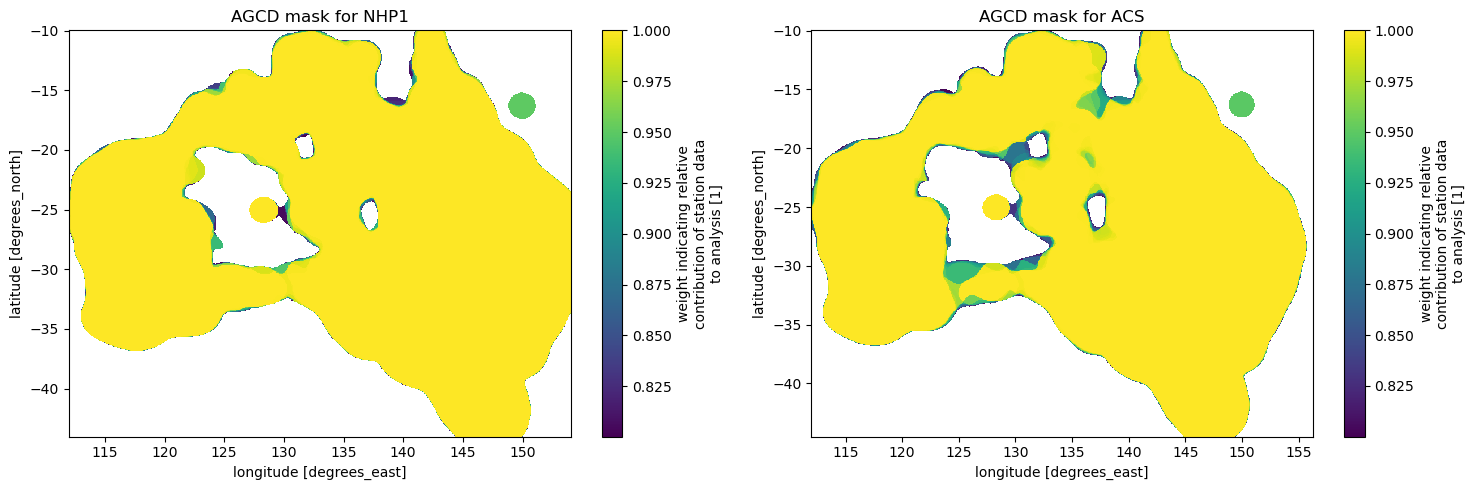

In [3]:
#< AGCD masking
mask_ds = xr.open_dataset("/g/data/mn51/users/dh4185/agcd_v1-0-2_precip_weight_r005_daily_1975_2005fraction_ge1.nc").sel(lat=slice(-44,-10),lon=slice(112,154))
q_mask = np.ma.masked_greater(mask_ds.fraction,0.8)

# Mask for CCAM/BARPA
mask_ds_acs = xr.open_dataset("/g/data/mn51/users/dh4185/agcd_v1-0-2_precip_weight_r005_daily_1960_2022fraction_ge1.nc")
q_mask_acs = np.ma.masked_greater(mask_ds_acs.fraction,0.8)

# Create the subplots: 1 row, 2 columns
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

# Plot the first map on the left
mask_ds.fraction.where(q_mask.mask).plot(ax=axes[0])
axes[0].set_title('AGCD mask for NHP1')

# Plot the second map on the right
mask_ds_acs.fraction.where(q_mask_acs.mask).plot(ax=axes[1])
axes[1].set_title('AGCD mask for ACS')

plt.tight_layout()
plt.show()

### Using the shapefiles directly
Shapefile from Carly Tozer

    Regn_06                                 NPI_Nam   PLANT_A  \
0       1.0                       Western Australia  383400.0   
1       2.0                      Northern Territory   47600.0   
2       3.0  Mount Lofty Ranges and Kangaroo Island   33400.0   
3       4.0                          Green Triangle  336600.0   
4       5.0                     Northern Queensland   73200.0   
5       6.0                   South East Queensland  191700.0   
6       7.0                     Northern Tablelands   17400.0   
7       8.0                             North Coast   94500.0   
8       9.0                      Central Tablelands   86900.0   
9      10.0                     Southern Tablelands   22100.0   
10     11.0                           Murray Valley  196500.0   
11     12.0                        Central Victoria   67800.0   
12     13.0                       Central Gippsland   91700.0   
13     14.0                  East GippslandBombala   57400.0   
14     15.0              

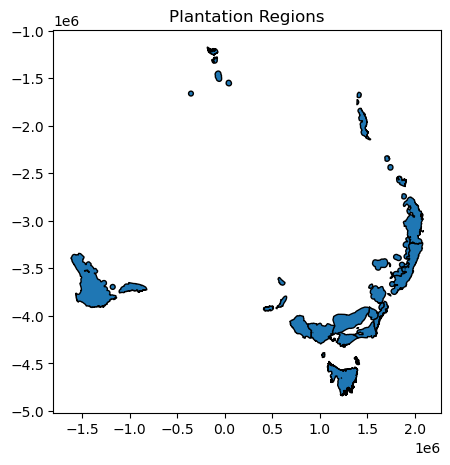

In [4]:
#< Read shapefile - NEW SHAPEFILES SENT BY BEC ON 9 OCTOBER
shp_file_dir = "/home/565/dh4185/mn51-dh4185/shapefiles/"

sf_raw = gpd.read_file(f"{shp_file_dir}Plantations2016_buffered_NPI_and_MUF.shp", crs="epsg:4326")
sf = sf_raw#.drop_duplicates(subset='Regn_06')

# Inspect the data to find the column with region names
print(sf)

# Plot the shapefile
sf.plot(edgecolor='black', figsize=(5, 5))
plt.title("Plantation Regions")
plt.show()

### Process files for absolute values for each GWL for AI

In [12]:
gwl = ["GWL12","GWL15","GWL20","GWL30"]
root_dir = "/g/data/ia39/ncra/drought_aridity/ai/nhp1_BC_5km/GWL/"
save_dir = "/g/data/ia39/ncra/drought_aridity/ai/request_forestry/"
rcp = "rcp85"

list_prctl_gwls = []
list_mean_gwls = []

for _gwl in gwl:
    print(f'=============== {_gwl} ==============')
    list_model = []

    # for model in models:
    file = f'{root_dir}AI-atmospheric-based_NHP1-AUS-5_rcp85_bias-adjusted_2D_{_gwl}.nc'
    ds = xr.open_dataset(file).drop(['rcp','gwl']).where(q_mask.mask)

    ds.rio.set_spatial_dims(x_dim="lon", y_dim="lat", inplace=True)
    ds.rio.write_crs("epsg:4326", inplace=True)
    
    for _model in ds.model.data:
        print(f'------------- {_model} ------------')
        da = ds.sel(model=_model).AI

        da_mean = regional_mean_sf(da,sf)  
        # print(da_mean)
        list_model.append(da_mean) #> dims: region, model

    #< Concatenate all models for one GWL
    da_all = xr.concat(list_model,dim='model').expand_dims(dim={"gwl": [f"GWL{int(_gwl[3:])/10}"]})
    list_mean_gwls.append(da_all)

    da_prctl = da_all.quantile([0.1,0.5,0.9],dim='model').round(2)
    list_prctl_gwls.append(da_prctl)

##############> REQUEST 1): regional mean per model and GWL #############>
#< Concatenate all GWLs with regional mean for each model and gwl
da_mean_gwls = xr.concat(list_mean_gwls,dim='gwl')

# Tidy up region mean file
da_mean_gwls = da_mean_gwls.rename("AI_region_mean").drop(["spatial_ref"])
df_mean_gwls = da_mean_gwls.to_dataframe().reset_index().drop('region', axis=1)

# Save DataFrame to CSV
df_mean_gwls.to_csv(f'{save_dir}AI-atmospheric-based_NHP1-AUS-5_rcp85_bias-adjusted_plantation_region_mean_allGWLs.csv', index=False)  

##############> REQUEST 2): regional MMM percentiles for each GWL #############>
#< Concatenate all GWLs with MME percentiles (10th, 50th, 90th)
da_prctl_gwls = xr.concat(list_prctl_gwls,dim='gwl') 

# Tidy up region MME percentiles file
da_prctl_gwls = da_prctl_gwls.rename("AI_region_MME")
df_prctl_gwls = da_prctl_gwls.to_dataframe().reset_index().drop('region', axis=1)

# Save DataFrame to CSV
df_prctl_gwls.to_csv(f'{save_dir}AI-atmospheric-based_NHP1-AUS-5_rcp85_bias-adjusted_plantation_region_prctls_allGWLs.csv', index=False) 

=============== GWL12 ==============
------------- ACCESS1-0_CSIRO-CCAM-r3355-r240x120-ISIMIP2b ------------
------------- ACCESS1-0_r240x120-ISIMIP2b ------------
------------- ACCESS1-0_r240x120-MRNBC ------------
------------- ACCESS1-0_r240x120-QME ------------
------------- CNRM-CM5_CSIRO-CCAM-r3355-r240x120-ISIMIP2b ------------
------------- CNRM-CM5_r240x120-ISIMIP2b ------------
------------- CNRM-CM5_r240x120-MRNBC ------------
------------- CNRM-CM5_r240x120-QME ------------
------------- GFDL-ESM2M_CSIRO-CCAM-r3355-r240x120-ISIMIP2b ------------
------------- GFDL-ESM2M_r240x120-ISIMIP2b ------------
------------- GFDL-ESM2M_r240x120-MRNBC ------------
------------- GFDL-ESM2M_r240x120-QME ------------
------------- MIROC5_CSIRO-CCAM-r3355-r240x120-ISIMIP2b ------------
------------- MIROC5_r240x120-ISIMIP2b ------------
------------- MIROC5_r240x120-MRNBC ------------
------------- MIROC5_r240x120-QME ------------
=============== GWL15 ==============
------------- ACCESS1-

### Process files for relative change values for each GWL for AI

In [13]:
gwl = ["GWL15","GWL20","GWL30"]
root_dir = "/g/data/ia39/ncra/drought_aridity/ai/nhp1_BC_5km/GWL/"
save_dir = "/g/data/ia39/ncra/drought_aridity/ai/request_forestry/"
rcp = "rcp85"

list_prctl_gwls = []
list_mean_gwls = []

for _gwl in gwl:
    print(f'=============== {_gwl} ==============')
    list_model = []

    # for model in models:
    file = f'{root_dir}AI-atmospheric-based_NHP1-AUS-5_rcp85_bias-adjusted_2D_{_gwl}_prct-change-to-GWL12.nc'
    ds = xr.open_dataset(file).where(q_mask.mask)

    ds.rio.set_spatial_dims(x_dim="lon", y_dim="lat", inplace=True)
    ds.rio.write_crs("epsg:4326", inplace=True)
    
    for _model in ds.model.data:
        print(f'------------- {_model} ------------')
        da = ds.sel(model=_model).AI

        da_mean = regional_mean_sf(da,sf)  
        # print(da_mean)
        list_model.append(da_mean) #> dims: region, model

    #< Concatenate all models for one GWL
    da_all = xr.concat(list_model,dim='model') 
    da_all.expand_dims(dim={"gwl": [_gwl]})
    list_mean_gwls.append(da_all)

    da_prctl = da_all.quantile([0.1,0.5,0.9],dim='model').round(2)
    list_prctl_gwls.append(da_prctl)

#############> REQUEST 3): regional %-change mean per model and GWL #############>
#< Concatenate all GWLs with regional mean for each model and gwl
da_mean_gwls_change = xr.concat(list_mean_gwls,dim='gwl') 

# Tidy up region mean file
da_mean_gwls_change = da_mean_gwls_change.rename("AI %-change").drop(["spatial_ref"])
df_mean_gwls_change = da_mean_gwls_change.to_dataframe().reset_index().drop('region', axis=1)

# Save DataFrame to CSV
df_mean_gwls_change.to_csv(f'{save_dir}AI-atmospheric-based_NHP1-AUS-5_rcp85_bias-adjusted_plantation_region_change_mean_allGWLs.csv', index=False)  

#############> REQUEST 4): regional %-change MMM percentiles for each GWL #############>
#< Concatenate all GWLs with MME percentiles (10th, 50th, 90th)
da_prctl_gwls_change = xr.concat(list_prctl_gwls,dim='gwl') 

# Tidy up region MME percentiles file
da_prctl_gwls_change = da_prctl_gwls_change.rename("AI %-change")
df_prctl_gwls_change = da_prctl_gwls_change.to_dataframe().reset_index().drop('region', axis=1)

# Save DataFrame to CSV
df_prctl_gwls_change.to_csv(f'{save_dir}AI-atmospheric-based_NHP1-AUS-5_rcp85_bias-adjusted_plantation_region_change_prctls_allGWLs.csv', index=False) 

=============== GWL15 ==============
------------- ACCESS1-0_CSIRO-CCAM-r3355-r240x120-ISIMIP2b ------------
------------- ACCESS1-0__r240x120-ISIMIP2b ------------
------------- ACCESS1-0_r240x120-MRNBC ------------
------------- ACCESS1-0_r240x120-QME ------------
------------- CNRM-CM5_CSIRO-CCAM-r3355-r240x120-ISIMIP2b ------------
------------- CNRM-CM5__r240x120-ISIMIP2b ------------
------------- CNRM-CM5_r240x120-MRNBC ------------
------------- CNRM-CM5_r240x120-QME ------------
------------- GFDL-ESM2M_CSIRO-CCAM-r3355-r240x120-ISIMIP2b ------------
------------- GFDL-ESM2M__r240x120-ISIMIP2b ------------
------------- GFDL-ESM2M_r240x120-MRNBC ------------
------------- GFDL-ESM2M_r240x120-QME ------------
------------- MIROC5_CSIRO-CCAM-r3355-r240x120-ISIMIP2b ------------
------------- MIROC5__r240x120-ISIMIP2b ------------
------------- MIROC5_r240x120-MRNBC ------------
------------- MIROC5_r240x120-QME ------------
=============== GWL20 ==============
------------- ACCE

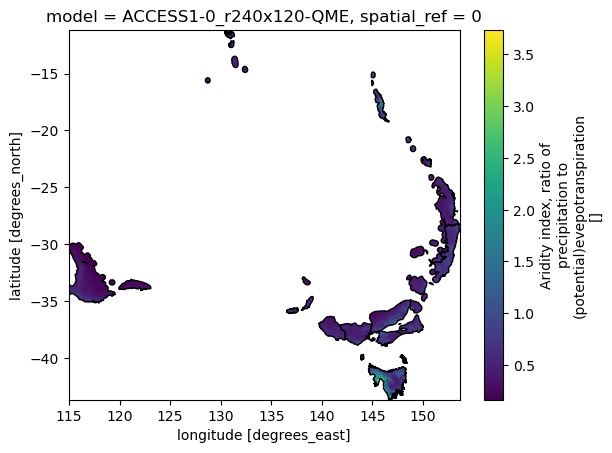

In [29]:
ax=sf.plot(facecolor='none',edgecolor='black')
pak=clipped.sel(model='ACCESS1-0_r240x120-QME').AI.plot(ax=ax,zorder=-1)
plt.show()


# SPI time spent in drought
Same process as above for AI

### Process files for absolute and change values for each GWL for SPI3

In [42]:
gwl = ["GWL1.2","GWL1.5","GWL2.0","GWL3.0"]
root_dir = "/g/data/ia39/ncra/drought_aridity/spi/downscaled_BC_5km/"
save_dir = "/g/data/ia39/ncra/drought_aridity/ai/request_forestry/"
rcp = "ssp370"

list_prctl_gwls = []
list_mean_gwls = []
list_mean_gwls_change = []
list_prctl_gwls_change = []

for _gwl in gwl:
    print(f'=============== {_gwl} ==============')
    list_model = []
    list_model_change = []

    files = lib_david.get_file_paths(root_dir, ".nc", include=[_gwl,'SPI3_pct_time_below_-1'],exclude=['percentile'])

    for file in files:
        _model = f"{file.split('_')[-5]}_{file.split('_')[-8]}"
        print(f'------------- {_model} ------------')

        ds = xr.open_dataset(file).where(q_mask_acs.mask)

        ds.rio.set_spatial_dims(x_dim="lon", y_dim="lat", inplace=True)
        ds.rio.write_crs("epsg:4326", inplace=True)

        da = ds.expand_dims(dim={"model": [_model]}).SPI3
    
        da_mean = regional_mean_sf(da,sf)
        list_model.append(da_mean) #> dims: region, model

        if _gwl == "GWL1.2":
            da_mean_gwl12 = da_mean
        else:
            da_mean_change = (((da_mean-da_mean_gwl12)/da_mean_gwl12)*100).round(1)
            list_model_change.append(da_mean_change)

    #< Concatenate all models for one GWL
    da_all = xr.concat(list_model,dim='model').expand_dims(dim={"gwl": [_gwl]})
    list_mean_gwls.append(da_all)

    da_prctl = da_all.quantile([0.1,0.5,0.9],dim='model').round(1)
    list_prctl_gwls.append(da_prctl)

    #< Concatenate all models for one GWL except 1.2 for changes
    if _gwl != "GWL1.2":
        da_all_change = xr.concat(list_model_change,dim='model').expand_dims(dim={"gwl": [_gwl]})
        list_mean_gwls_change.append(da_all_change)

        da_prctl_change = da_all_change.quantile([0.1,0.5,0.9],dim='model').round(1)
        list_prctl_gwls_change.append(da_prctl_change)


##############> REQUEST 1): regional mean per model and GWL #############>
#< Concatenate all GWLs with regional mean for each model and gwl
da_mean_gwls = xr.concat(list_mean_gwls,dim='gwl')

# Tidy up region mean file
da_mean_gwls = da_mean_gwls.rename("SPI3_tsid_region_mean").drop(["spatial_ref"])
df_mean_gwls = da_mean_gwls.to_dataframe().reset_index().drop('region', axis=1)

# Save DataFrame to CSV
df_mean_gwls.to_csv(f'{save_dir}SPI3_pct_time_below_-1_ssp370_baseperiod19652014_ACS-QME-AGCD-1960-2022_plantation_region_mean_allGWLs.csv', index=False)  

##############> REQUEST 2): regional MMM percentiles for each GWL #############>
#< Concatenate all GWLs with MME percentiles (10th, 50th, 90th)
da_prctl_gwls = xr.concat(list_prctl_gwls,dim='gwl') 

# Tidy up region MME percentiles file
da_prctl_gwls = da_prctl_gwls.rename("SPI3_tsid_region_MME")
df_prctl_gwls = da_prctl_gwls.to_dataframe().reset_index().drop('region', axis=1)

# # Save DataFrame to CSV
df_prctl_gwls.to_csv(f'{save_dir}SPI3_pct_time_below_-1_ssp370_baseperiod19652014_ACS-QME-AGCD-1960-2022_plantation_region_prctls_allGWLs.csv', index=False) 

#############> REQUEST 3): regional %-change mean per model and GWL #############>
#< Concatenate all GWLs with regional mean for each model and gwl
da_mean_gwls_change = xr.concat(list_mean_gwls_change,dim='gwl') 

# Tidy up region mean file
da_mean_gwls_change = da_mean_gwls_change.rename("SPI3 %-change").drop(["spatial_ref"])
df_mean_gwls_change = da_mean_gwls_change.to_dataframe().reset_index().drop('region', axis=1)

# Save DataFrame to CSV
df_mean_gwls_change.to_csv(f'{save_dir}SPI3_pct_time_below_-1_ssp370_baseperiod19652014_ACS-QME-AGCD-1960-2022_plantation_region_change_mean_allGWLs.csv', index=False)  

#############> REQUEST 4): regional %-change MMM percentiles for each GWL #############>
#< Concatenate all GWLs with MME percentiles (10th, 50th, 90th)
da_prctl_gwls_change = xr.concat(list_prctl_gwls_change,dim='gwl') 

# Tidy up region MME percentiles file
da_prctl_gwls_change = da_prctl_gwls_change.rename("SPI3 %-change")
df_prctl_gwls_change = da_prctl_gwls_change.to_dataframe().reset_index().drop('region', axis=1)

# Save DataFrame to CSV
df_prctl_gwls_change.to_csv(f'{save_dir}SPI3_pct_time_below_-1_ssp370_baseperiod19652014_ACS-QME-AGCD-1960-2022_plantation_region_change_prctls_allGWLs.csv', index=False) 

=============== GWL1.2 ==============
------------- CSIRO_CESM2 ------------
------------- BOM_NorESM2-MM ------------
------------- CSIRO_ACCESS-CM2 ------------
------------- CSIRO_ACCESS-ESM1-5 ------------
------------- BOM_MPI-ESM1-2-HR ------------
------------- BOM_CESM2 ------------
------------- CSIRO_CMCC-ESM2 ------------
------------- BOM_CMCC-ESM2 ------------
------------- BOM_ACCESS-ESM1-5 ------------
------------- BOM_EC-Earth3 ------------
------------- BOM_ACCESS-CM2 ------------
------------- CSIRO_EC-Earth3 ------------
------------- CSIRO_CNRM-ESM2-1 ------------
=============== GWL1.5 ==============
------------- BOM_NorESM2-MM ------------
------------- BOM_ACCESS-ESM1-5 ------------
------------- CSIRO_CESM2 ------------
------------- CSIRO_CMCC-ESM2 ------------
------------- CSIRO_CNRM-ESM2-1 ------------
------------- BOM_CMCC-ESM2 ------------
------------- BOM_EC-Earth3 ------------
------------- BOM_ACCESS-CM2 ------------
------------- CSIRO_ACCESS-ESM1-

### Process files for relative change values for each GWL for AI

In [43]:
df_prctl_gwls_change

,quantile,gwl,Regn_Nm,Regn_06,SPI3 %-change
0,0.1,GWL1.5,Western Australia,1.0,-5.1
1,0.1,GWL1.5,Northern Territory,2.0,5.8
2,0.1,GWL1.5,Mount Lofty Ranges and Kangaroo Island,3.0,4.7
3,0.1,GWL1.5,Green Triangle,4.0,52.4
4,0.1,GWL1.5,Northern Queensland,5.0,-21.1
...,...,...,...,...,...
148,0.9,GWL3.0,Central Gippsland,13.0,175.9
149,0.9,GWL3.0,East GippslandBombala,14.0,183.8
150,0.9,GWL3.0,Tasmania,15.0,272.9
151,0.9,GWL3.0,Pilliga,20.0,92.8


In [44]:
df_mean_gwls_change

,gwl,model,Regn_Nm,Regn_06,SPI3 %-change
0,GWL1.5,CSIRO_CNRM-ESM2-1,Western Australia,1.0,104.1
1,GWL1.5,CSIRO_CNRM-ESM2-1,Northern Territory,2.0,97.9
2,GWL1.5,CSIRO_CNRM-ESM2-1,Mount Lofty Ranges and Kangaroo Island,3.0,64.5
3,GWL1.5,CSIRO_CNRM-ESM2-1,Green Triangle,4.0,119.4
4,GWL1.5,CSIRO_CNRM-ESM2-1,Northern Queensland,5.0,24.0
...,...,...,...,...,...
658,GWL3.0,CSIRO_CNRM-ESM2-1,Central Gippsland,13.0,-36.5
659,GWL3.0,CSIRO_CNRM-ESM2-1,East GippslandBombala,14.0,-51.4
660,GWL3.0,CSIRO_CNRM-ESM2-1,Tasmania,15.0,31.8
661,GWL3.0,CSIRO_CNRM-ESM2-1,Pilliga,20.0,-55.7


# 15th rainfall percentile
Same process as above 

### Process files for absolute and change values for each GWL for 15th rainfall percentile

In [12]:
gwl = ["GWL1.2","GWL1.5","GWL2.0","GWL3.0"]
root_dir = "/g/data/ia39/ncra/drought_aridity/rainfall_percentiles/downscaled_BC_5km/GWLs/"
save_dir = "/g/data/ia39/ncra/drought_aridity/ai/request_forestry/"
rcp = "ssp370"

list_prctl_gwls = []
list_mean_gwls = []
list_mean_gwls_change = []
list_prctl_gwls_change = []

for _gwl in gwl:
    print(f'=============== {_gwl} ==============')
    list_model = []
    list_model_change = []

    files = lib_david.get_file_paths(root_dir, ".nc", include=[_gwl,'p15_3month_'],exclude=['percentile'])

    for file in files:
        _model = f"{file.split('_')[-4]}_{file.split('_')[-7]}"
        
        print(f'------------- {_model} ------------')
        ds = xr.open_dataset(file).where(q_mask_acs.mask)

        ds.rio.set_spatial_dims(x_dim="lon", y_dim="lat", inplace=True)
        ds.rio.write_crs("epsg:4326", inplace=True)

        da = ds.mean('month').expand_dims(dim={"model": [_model]}).p15_3month
    
        da_mean = regional_mean_sf(da,sf)
        list_model.append(da_mean) #> dims: region, model

        if _gwl == "GWL1.2":
            da_mean_gwl12 = da_mean
        else:
            da_mean_change = (da_mean-da_mean_gwl12).round(1).expand_dims(dim={"model": [_model]})
            list_model_change.append(da_mean_change)

    #< Concatenate all models for one GWL
    da_all = xr.concat(list_model,dim='model').expand_dims(dim={"gwl": [_gwl]})
    list_mean_gwls.append(da_all)

    da_prctl = da_all.quantile([0.1,0.5,0.9],dim='model').round(1)
    list_prctl_gwls.append(da_prctl)

    #< Concatenate all models for one GWL except 1.2 for changes
    if _gwl != "GWL1.2":
        da_all_change = xr.concat(list_model_change,dim='model').expand_dims(dim={"gwl": [_gwl]})
        list_mean_gwls_change.append(da_all_change)

        da_prctl_change = da_all_change.quantile([0.1,0.5,0.9],dim='model').round(1)
        list_prctl_gwls_change.append(da_prctl_change)


##############> REQUEST 1): regional mean per model and GWL #############>
#< Concatenate all GWLs with regional mean for each model and gwl
da_mean_gwls = xr.concat(list_mean_gwls,dim='gwl')

# Tidy up region mean file
da_mean_gwls = da_mean_gwls.rename("p15_3month_region_mean").drop(["spatial_ref","quantile"])
df_mean_gwls = da_mean_gwls.to_dataframe().reset_index().drop('region', axis=1)

# Save DataFrame to CSV
df_mean_gwls.to_csv(f'{save_dir}p15_3month_ssp370_ACS-QME-AGCD-1960-2022_plantation_region_mean_allGWLs.csv', index=False)  

##############> REQUEST 2): regional MMM percentiles for each GWL #############>
#< Concatenate all GWLs with MME percentiles (10th, 50th, 90th)
da_prctl_gwls = xr.concat(list_prctl_gwls,dim='gwl') 

# Tidy up region MME percentiles file
da_prctl_gwls = da_prctl_gwls.rename("p15_3month_region_MME")
df_prctl_gwls = da_prctl_gwls.to_dataframe().reset_index().drop('region', axis=1)

# # Save DataFrame to CSV
df_prctl_gwls.to_csv(f'{save_dir}p15_3month_ssp370_ACS-QME-AGCD-1960-2022_plantation_region_prctls_allGWLs.csv', index=False) 

#############> REQUEST 3): regional %-change mean per model and GWL #############>
#< Concatenate all GWLs with regional mean for each model and gwl
da_mean_gwls_change = xr.concat(list_mean_gwls_change,dim='gwl') 

# Tidy up region mean file
da_mean_gwls_change = da_mean_gwls_change.rename("p15_3month abs-change").drop(["spatial_ref","quantile"])
df_mean_gwls_change = da_mean_gwls_change.to_dataframe().reset_index().drop('region', axis=1)

# Save DataFrame to CSV
df_mean_gwls_change.to_csv(f'{save_dir}p15_3month_ssp370_ACS-QME-AGCD-1960-2022_plantation_region_change_mean_allGWLs.csv', index=False)  

#############> REQUEST 4): regional %-change MMM percentiles for each GWL #############>
#< Concatenate all GWLs with MME percentiles (10th, 50th, 90th)
da_prctl_gwls_change = xr.concat(list_prctl_gwls_change,dim='gwl') 

# Tidy up region MME percentiles file
da_prctl_gwls_change = da_prctl_gwls_change.rename("p15_3month abs-change")
df_prctl_gwls_change = da_prctl_gwls_change.to_dataframe().reset_index().drop('region', axis=1)

# Save DataFrame to CSV
df_prctl_gwls_change.to_csv(f'{save_dir}p15_3month_ssp370_ACS-QME-AGCD-1960-2022_plantation_region_change_prctls_allGWLs.csv', index=False) 


=============== GWL1.2 ==============
------------- CSIRO_EC-Earth3 ------------
------------- BOM_ACCESS-CM2 ------------
------------- CSIRO_CESM2 ------------
------------- BOM_MPI-ESM1-2-HR ------------
------------- CSIRO_CNRM-ESM2-1 ------------
------------- BOM_CESM2 ------------
------------- CSIRO_ACCESS-ESM1-5 ------------
------------- CSIRO_CMCC-ESM2 ------------
------------- BOM_EC-Earth3 ------------
------------- BOM_CMCC-ESM2 ------------
------------- BOM_ACCESS-ESM1-5 ------------
------------- BOM_NorESM2-MM ------------
------------- CSIRO_ACCESS-CM2 ------------
=============== GWL1.5 ==============
------------- CSIRO_CNRM-ESM2-1 ------------
------------- BOM_CMCC-ESM2 ------------
------------- CSIRO_CMCC-ESM2 ------------
------------- CSIRO_EC-Earth3 ------------
------------- BOM_MPI-ESM1-2-HR ------------
------------- CSIRO_CESM2 ------------
------------- CSIRO_ACCESS-CM2 ------------
------------- CSIRO_ACCESS-ESM1-5 ------------
------------- BOM_NorES